In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [2]:
# Gerekli Kütüphaneleri Yükleme
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier #
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap 
import re

# Özel veri ön işleme fonksiyonumuzu import et
from preprocessing import load_and_preprocess_data

# Yapay Zeka Destekli Hücre Tepkisi Tahmin Modeli: Silika Nanopartikül Pertürbasyonu

Bu Jupyter Notebook, `GSE53700` veri setini kullanarak A549 hücrelerinin silika nanopartikül (SM30 NPs) maruziyetine verdiği gen ekspresyon tepkilerini analiz etmeyi ve bu tepkileri tahmin eden bir yapay zeka sınıflandırma modeli geliştirmeyi amaçlamaktadır.

--- 1. Veri Yükleme ve Ön İşleme ---

Öncelikle, hazırladığım `preprocessing.py` script'ini kullanarak ham veriyi yükleyip, makine öğrenimi modeline uygun hale getireceğim.
Bu adımda gen ekspresyon matrisi (X) ve pertürbasyon etiketleri (Y) elde edilecek, ayrıca veriler normalize edilecektir.

Veri seti, A549 insan akciğer adenokarsinomu hücrelerinin `Ludox® SM30` silika nanopartikülleri (9nm çapında) ile muamele edildiği deneylerden elde edilmiştir. Makaleye göre, gen ekspresyon analizleri `0.02 mg/mL` dozunda NP maruziyeti ve ardından `3 saat` veya `22 saat` 'recovery' (iyileşme) süreleriyle yapılmıştır. Kontrol hücreleri ise NP'ye maruz kalmamıştır.

In [3]:
# Veriyi yükle ve ön işleme
X, Y_encoded, label_encoder, platform_df = load_and_preprocess_data(
    gene_expression_filepath='../data/processed_gene_expression_matrix.csv',
    metadata_filepath='../data/sample_metadata.csv',
    soft_file_path='../data/GSE53700_family.soft' 
)

if X is None:
    print("Veri yükleme veya ön işleme sırasında hata oluştu. Lütfen konsol çıktılarını kontrol edin.")
else:
    print("\nVeri Yükleme ve Ön İşleme Başarılı.")
    print(f"Hazırlanmış Gen Ekspresyon Matrisi (X) Boyutu: {X.shape}")
    print(f"Kodlanmış Etiketler (Y) Boyutu: {Y_encoded.shape}")
    print(f"Sınıf Etiketleri: {label_encoder.classes_}")
    print(f"Platform Tablosu Boyutu: {platform_df.shape}")

    # X'in indeksini (sample_id'ler) ve sütunlarını (gen ID'leri) kontrol et
    print("\nX'in ilk 5 satırının indeksi (Sample IDs):")
    print(X.index[:5])
    print("\nX'in ilk 5 sütununun başlıkları (Gene IDs):")
    print(X.columns[:5])

Veri yükleniyor ve ön işleme tabi tutuluyor...
'../data/GSE53700_family.soft' dosyası okunuyor...
Veri dosyaları yükleniyor...
Gen Ekspresyon Matrisi Boyutu (Yüklendi): (24001, 18)
Sample Metadata Boyutu (Yüklendi): (18, 36)
Pertürbasyon etiketleri çıkarılıyor...
Oluşturulan Pertürbasyon Etiketleri (İlk 5): ['SM30_9nm_NP_3hrs' 'SM30_9nm_NP_3hrs' 'SM30_9nm_NP_3hrs'
 'SM30_9nm_NP_3hrs' 'SM30_9nm_NP_3hrs']
Etiketlerin Dağılımı:
 SM30_9nm_NP_3hrs      6
AS30_18nm_NP_3hrs     6
AS30_18nm_NP_22hrs    6
Name: count, dtype: int64
Gen ekspresyon verisi normalize ediliyor...
Gen Ekspresyon Matrisi Boyutu (Transpoze Edilmiş): (18, 24001)
Veri ön işleme tamamlandı.
Veri ön işleme tamamlandı.

Veri Yükleme ve Ön İşleme Başarılı.
Hazırlanmış Gen Ekspresyon Matrisi (X) Boyutu: (18, 24001)
Kodlanmış Etiketler (Y) Boyutu: (18,)
Sınıf Etiketleri: ['AS30_18nm_NP_22hrs' 'AS30_18nm_NP_3hrs' 'SM30_9nm_NP_3hrs']
Platform Tablosu Boyutu: (41109, 17)

X'in ilk 5 satırının indeksi (Sample IDs):
Index(['GSM12991

PCA

Modellemeye başlamadan önce, gen ekspresyon verilerimizin nasıl kümelendiğini veya ayrıştığını görselleştirmek için Temel Bileşenler Analizi (PCA) uygulayacağız. Bu, veri setindeki farklı pertürbasyon koşullarının gen ekspresyon profillerinde belirgin 'imzalar' bırakıp bırakmadığını anlamamıza yardımcı olur. 

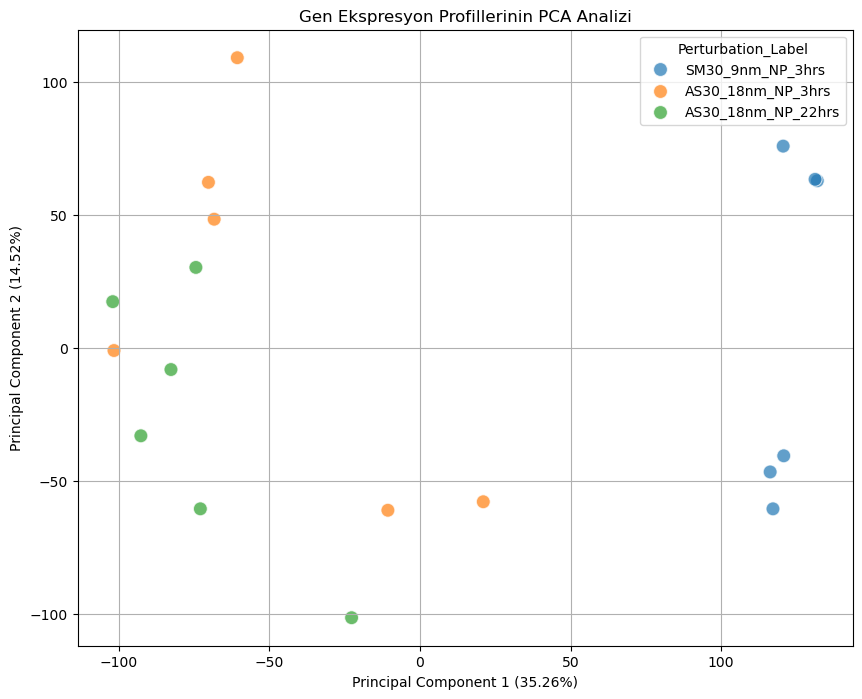

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Orijinal etiketleri çöz
Y_labels_decoded = label_encoder.inverse_transform(Y_encoded)

# PCA analizi (ilk 2 bileşen)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)  # X: en ekspresyon matrisi

# PCA sonuçlarını DataFrame'e koy
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=X.index)
pca_df['Perturbation_Label'] = Y_labels_decoded

# Görselleştir
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Perturbation_Label', data=pca_df, s=100, alpha=0.7)
plt.title('Gen Ekspresyon Profillerinin PCA Analizi')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.grid(True)
plt.show()

Yukarıdaki PCA grafiği, A549 hücrelerinin gen ekspresyon profillerini kullanarak farklı nanopartikül maruziyet koşulları (`SM30_9nm_NP_3hrs`, `AS30_18nm_NP_3hrs`, `AS30_18nm_NP_22hrs`) arasındaki ayrımı net bir şekilde göstermektedir.

*   **SM30 Nanopartikülünün Belirgin Etkisi:** Mavi noktalar (`SM30_9nm_NP_3hrs`), PC1 ekseni boyunca diğer tüm gruplardan dramatik bir şekilde ayrışmaktadır. Bu durum, 9nm'lik SM30 nanopartikül maruziyetinin gen ekspresyonunda çok güçlü ve ayırt edici bir 'imza' bıraktığını kanıtlamaktadır. PC1, varyansın %35.26'sını açıklayarak bu etkinin baskınlığını vurgular.
*   **AS30 Grupları Arası Ayrım (Zaman Etkisi):** `AS30_18nm_NP_3hrs` (turuncu) ve `AS30_18nm_NP_22hrs` (yeşil) grupları PC1 üzerinde daha yakın kümelenirken, PC2 ekseni (varyansın %14.52'si) üzerinde belirgin bir ayrım göstermektedir. Bu, AS30 nanopartikülüne maruz kalmış hücrelerin genetik profillerinde zaman geçişinin (3 saatten 22 saate) de önemli değişikliklere yol açtığını ve modelimizin bu farklılıkları ayırt edebileceğini işaret etmektedir.

Bu analiz, AI modelimizin farklı nanopartikül tipi ve maruziyet süresi koşullarını gen ekspresyon profillerinden başarılı bir şekilde ayırt edebilmesi için veride güçlü ve ayrıştırılabilir sinyaller bulunduğunu görsel olarak kanıtlamaktadır. Makaledeki PCA bulgularıyla da uyumludur.

--- 2. Veriyi Eğitim ve Test Setlerine Ayırma ---

Modelin genellenme yeteneğini değerlendirmek için veriyi eğitim ve test setlerine ayırıyoruz. `stratify=Y_encoded` parametresi, sınıf dağılımlarının hem eğitim hem de test setlerinde benzer olmasını sağlar, bu özellikle küçük ve dengesiz veri setlerinde önemlidir.

**Not:** Toplam 18 örneklik küçük bir veri setiyle çalıştığımız için, eğitim ve test setlerinin boyutları da oldukça küçüktür (12 eğitim, 6 test örneği). Bu durum, modelin genelleme yeteneği hakkında kesin yargılara varmayı zorlaştırabilir. 

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_encoded, test_size=0.3, random_state=42, stratify=Y_encoded
)

print("\nVeri Eğitim/Test Setlerine Ayrıldı:")
print(f"Eğitim Seti (X_train) Boyutu: {X_train.shape}")
print(f"Eğitim Etiketleri (Y_train) Boyutu: {Y_train.shape}")
print(f"Test Seti (X_test) Boyutu: {X_test.shape}")
print(f"Test Etiketleri (Y_test) Boyutu: {Y_test.shape}")

# Her bir setteki sınıf dağılımını kontrol et
print("\nEğitim Seti Sınıf Dağılımı:")
print(pd.Series(Y_train).map(lambda x: label_encoder.inverse_transform([x])[0]).value_counts())
print("\nTest Seti Sınıf Dağılımı:")
print(pd.Series(Y_test).map(lambda x: label_encoder.inverse_transform([x])[0]).value_counts())


Veri Eğitim/Test Setlerine Ayrıldı:
Eğitim Seti (X_train) Boyutu: (12, 24001)
Eğitim Etiketleri (Y_train) Boyutu: (12,)
Test Seti (X_test) Boyutu: (6, 24001)
Test Etiketleri (Y_test) Boyutu: (6,)

Eğitim Seti Sınıf Dağılımı:
SM30_9nm_NP_3hrs      4
AS30_18nm_NP_22hrs    4
AS30_18nm_NP_3hrs     4
Name: count, dtype: int64

Test Seti Sınıf Dağılımı:
AS30_18nm_NP_3hrs     2
SM30_9nm_NP_3hrs      2
AS30_18nm_NP_22hrs    2
Name: count, dtype: int64


--- 3. Model Eğitimi (Random Forest Sınıflandırma) ---

Gen ekspresyon profillerinden pertürbasyon tipini ve zamanını tahmin etmek için bir sınıflandırma modeli eğiteceğiz. Random Forest, hem iyi performans gösteren hem de özellik önem düzeylerini (feature importance) sağlaması nedeniyle tercih edilmiştir. Bu model, makalede kullanılan istatistiksel analiz yöntemlerinin (ANOVA, PCA) otomatize edilmiş bir uzantısı gibi düşünülebilir.

In [6]:
# Modeli başlat ve eğit
model = RandomForestClassifier(n_estimators=100, random_state=42)
print("\nRandom Forest modeli eğitiliyor...")
model.fit(X_train, Y_train)
print("Model eğitimi tamamlandı.")


Random Forest modeli eğitiliyor...
Model eğitimi tamamlandı.


--- 3b. Model Eğitimi (Logistic Regression Sınıflandırma) ---

Random Forest'ın performansını karşılaştırmak ve doğrusal ilişkileri test etmek için basit bir Lojistik Regresyon modeli de eğiteceğiz.

In [7]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
print("\nLogistic Regression modeli eğitiliyor...")
logreg_model.fit(X_train, Y_train)
print("Model eğitimi tamamlandı.")


Logistic Regression modeli eğitiliyor...
Model eğitimi tamamlandı.


--- 4. Model Değerlendirme ---

Eğitilen modelin test seti üzerindeki performansını çeşitli metriklerle değerlendireceğiz. Doğruluk (Accuracy), Hassasiyet (Precision), Duyarlılık (Recall), F1-Skoru ve ROC AUC gibi metrikler kullanılacaktır.

In [8]:
# Random Forest değerlendirme
Y_pred_rf = model.predict(X_test)
Y_pred_proba_rf = model.predict_proba(X_test)
accuracy_rf = accuracy_score(Y_test, Y_pred_rf)
roc_auc_rf = roc_auc_score(Y_test, Y_pred_proba_rf, multi_class='ovr')

print("Random Forest Model Doğruluğu (Accuracy): {:.4f}".format(accuracy_rf))
print("\nRandom Forest Sınıflandırma Raporu:")
print(classification_report(Y_test, Y_pred_rf, target_names=label_encoder.classes_))
print("Random Forest Ortalama ROC AUC Skoru (One-vs-Rest): {:.4f}".format(roc_auc_rf))

Random Forest Model Doğruluğu (Accuracy): 0.6667

Random Forest Sınıflandırma Raporu:
                    precision    recall  f1-score   support

AS30_18nm_NP_22hrs       0.67      1.00      0.80         2
 AS30_18nm_NP_3hrs       0.00      0.00      0.00         2
  SM30_9nm_NP_3hrs       0.67      1.00      0.80         2

          accuracy                           0.67         6
         macro avg       0.44      0.67      0.53         6
      weighted avg       0.44      0.67      0.53         6

Random Forest Ortalama ROC AUC Skoru (One-vs-Rest): 0.9167


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
# Logistic Regression değerlendirme
Y_pred_logreg = logreg_model.predict(X_test)
Y_pred_proba_logreg = logreg_model.predict_proba(X_test)
accuracy_logreg = accuracy_score(Y_test, Y_pred_logreg)
roc_auc_logreg = roc_auc_score(Y_test, Y_pred_proba_logreg, multi_class='ovr')

print("\nLogistic Regression Model Doğruluğu (Accuracy): {:.4f}".format(accuracy_logreg))
print("\nLogistic Regression Sınıflandırma Raporu:")
print(classification_report(Y_test, Y_pred_logreg, target_names=label_encoder.classes_))
print("Logistic Regression Ortalama ROC AUC Skoru (One-vs-Rest): {:.4f}".format(roc_auc_logreg))


Logistic Regression Model Doğruluğu (Accuracy): 0.6667

Logistic Regression Sınıflandırma Raporu:
                    precision    recall  f1-score   support

AS30_18nm_NP_22hrs       0.67      1.00      0.80         2
 AS30_18nm_NP_3hrs       0.00      0.00      0.00         2
  SM30_9nm_NP_3hrs       0.67      1.00      0.80         2

          accuracy                           0.67         6
         macro avg       0.44      0.67      0.53         6
      weighted avg       0.44      0.67      0.53         6

Logistic Regression Ortalama ROC AUC Skoru (One-vs-Rest): 1.0000


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


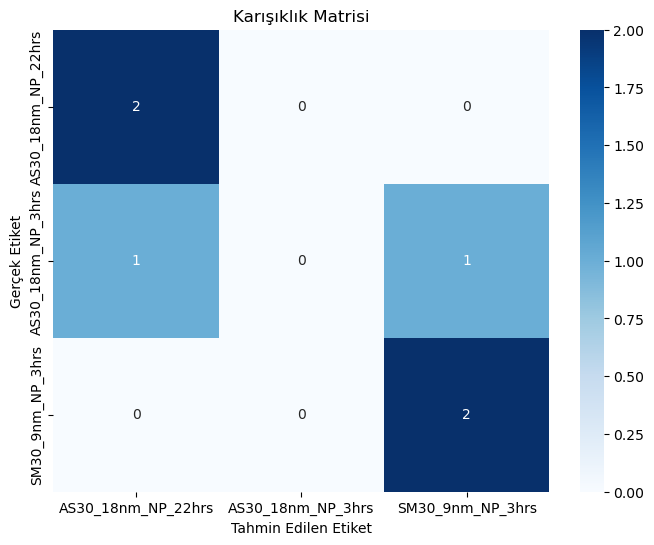

In [10]:
# Confusion Matrix (Karışıklık Matrisi)
# Modelin hangi sınıfları doğru/yanlış tahmin ettiğini görselleştirir.
cm = confusion_matrix(Y_test, Y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.show()

--- 5. Özellik Önem Düzeyleri (Feature Importance) ve Biyolojik Yorumlama ---

Random Forest modeli, hangi genlerin pertürbasyon tipini ve zamanını tahmin etmede en etkili olduğunu gösteren özellik önem düzeyleri sağlar. Bu genler, silika nanopartikül maruziyetine hücrelerin verdiği kritik biyolojik tepkilerle ilişkili olabilir. Bu analiz, makalede bahsedilen 'gene-by-gene' yaklaşımına benzer şekilde, gen ekspresyonundaki anahtar değişiklikleri tespit etmemizi sağlar.


En Önemli 20 Gen Probu (Pertürbasyon Tahmini için):
ID_REF
A_23_P138194    0.007561
A_23_P148372    0.007561
A_23_P149892    0.007561
A_23_P379475    0.007561
A_23_P8906      0.007561
A_24_P312164    0.007561
A_24_P6921      0.007561
A_24_P713312    0.007561
A_23_P145584    0.007538
A_23_P340123    0.007538
A_23_P60499     0.007538
A_24_P197964    0.007538
A_24_P386639    0.007538
A_24_P744148    0.007538
A_24_P911259    0.007538
A_32_P12430     0.007538
A_23_P123010    0.007429
A_23_P126393    0.007429
A_23_P56163     0.007241
A_23_P214281    0.006667
dtype: float64


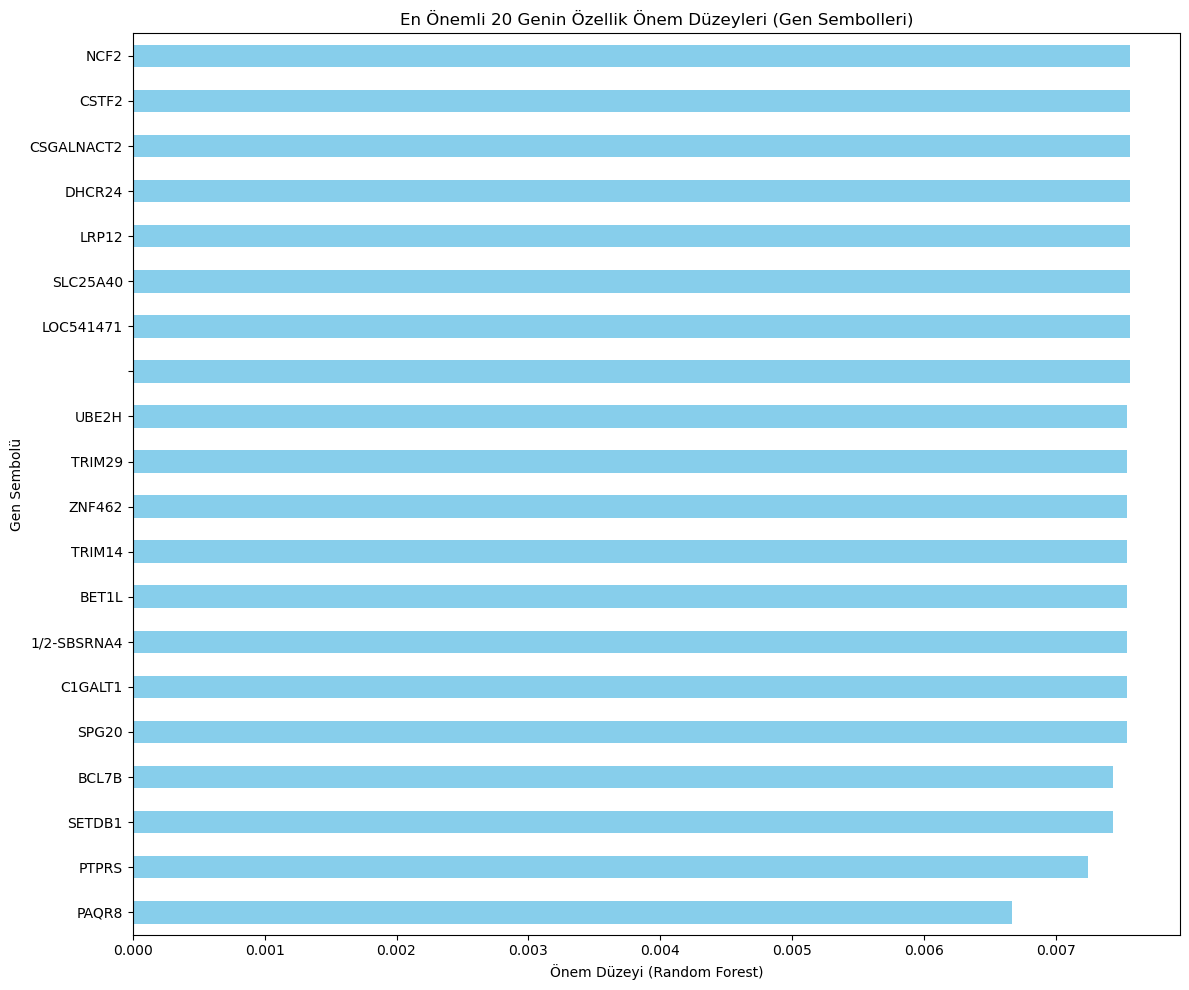

In [12]:
# Genlerin önem düzeylerini al
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
top_genes_probes = feature_importances.nlargest(20) # En önemli 20 gen probu ID'si

print("\nEn Önemli 20 Gen Probu (Pertürbasyon Tahmini için):")
print(top_genes_probes)

# `ID` sütunundaki prob ID'leri ile `GENE_SYMBOL` sütununu eşlemek için bir dictionary oluştur
probe_to_gene = platform_df.set_index('ID')['GENE_SYMBOL'].to_dict() 

# top_genes_probes'taki prob ID'lerini gen sembolleriyle değiştir
top_genes_symbols = top_genes_probes.rename(index=probe_to_gene)

# Özellik önem düzeylerini görselleştir (şimdi gen sembolleriyle)
plt.figure(figsize=(12, 10)) # Grafiği büyütelim ki etiketler okunabilsin
top_genes_symbols.sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title('En Önemli 20 Genin Özellik Önem Düzeyleri (Gen Sembolleri)')
plt.xlabel('Önem Düzeyi (Random Forest)')
plt.ylabel('Gen Sembolü')
plt.tight_layout()
plt.show()


SHAP Analizi Başlatılıyor (Özelliklerin Model Çıktısına Katkısı)...


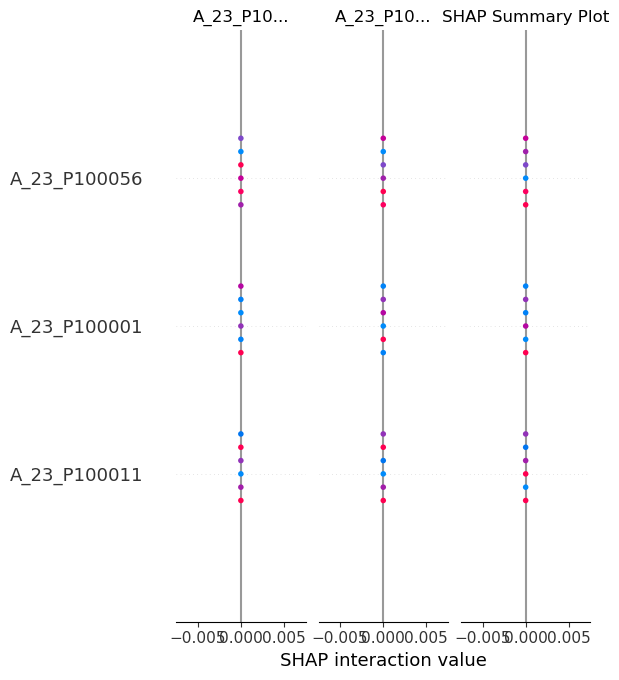

In [ ]:
# SHAP (SHapley Additive exPlanations) ile özellik önemini daha detaylı inceleme
# SHAP, bir özelliğin model çıktısı üzerindeki marjinal katkısını gösterir.
# Küçük örnek sayısıyla bile daha derinlemesine bir analiz sunabilir.
print("\nSHAP Analizi Başlatılıyor (Özelliklerin Model Çıktısına Katkısı)...")
try:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    if isinstance(shap_values, list): # Multi-class classification
        shap.summary_plot(shap_values[0], X_test, feature_names=X.columns, show=False)
        plt.title(f'SHAP Summary Plot for {label_encoder.classes_[0]} Class')
        plt.show()
        
        avg_abs_shap = np.mean(np.abs(np.array(shap_values)), axis=0).T
        global_shap_importance = pd.Series(np.mean(avg_abs_shap, axis=1), index=X.columns)
        top_shap_genes = global_shap_importance.nlargest(20)
        
        print("\nEn Önemli 20 Gen (SHAP Değerlerine Göre):")
        print(top_shap_genes)
        
        plt.figure(figsize=(10, 8))
        top_shap_genes.sort_values(ascending=True).plot(kind='barh', color='lightcoral')
        plt.title('En Önemli 20 Gen (SHAP Değerlerine Göre)')
        plt.xlabel('Ortalama Mutlak SHAP Değeri')
        plt.ylabel('Gen ID (Probe ID)')
        plt.tight_layout()
        plt.show()

    else: # Binary classification
        shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
        plt.title('SHAP Summary Plot')
        plt.show()

except Exception as e:
    print(f"SHAP analizi sırasında bir hata oluştu: {e}")
    print("SHAP kütüphanesi yüklenmemiş veya model uygun değil olabilir.")

--- 6. Sanal Hücre Modellemeleriyle Entegrasyon Potansiyeli ---

Bu bölümde, projenin sonuçlarını biyolojik bağlamda yorumlayacak ve `sanal hücre` (virtual cell) konseptiyle nasıl birleştiğini açıklayacağız. Geliştirdiğimiz AI modeli, sanal hücre modellerinde simüle edilen biyolojik tepkileri anlamak ve tahmin etmek için temel bir yapı taşı olarak hizmet edebilir.

## Sanal Hücre Entegrasyonu Senaryoları

### 1. Sanal Hücre Tepkilerinin Sınıflandırılması ve Doğrulanması

Geliştirdiğimiz sınıflandırma modeli (`Random Forest` veya `Logistic Regression`), belirli bir pertürbasyona maruz kalan bir **sanal hücreden elde edilen gen ekspresyon profillerini yorumlamak için kullanılabilir.** Örneğin:
- Sanal bir A549 hücresi modeline 'sanal' olarak silika nanopartikülü uygulandığında, bu modelin üreteceği 'sanal' gen ekspresyon verisi, AI modelimize girdi olarak verilebilir.
- AI modelimiz, bu sanal veriden hareketle, sanal hücrenin maruz kaldığı pertürbasyon tipini ve zamanını tahmin edebilir (örn: "Bu sanal hücre SM30 nanopartikülüne 3 saat maruz kalmış gibi görünüyor" veya "Bu sanal hücre kontrol grubuna ait").
- Bu sayede, sanal hücre modelinin simülasyonları, gerçek biyolojik tepkilerle ne kadar tutarlı olduğunu doğrulamak için hızlı ve otomatik bir şekilde değerlendirilebilir. Makaledeki PCA analizi de, farklı pertürbasyonların gen ekspresyon imzalarını nasıl ayırdığını göstererek bu entegrasyon potansiyelini desteklemektedir.

### 2. Yeni Pertürbasyonların Sanal Ortamda Keşfi ve Tahmini (İleriye Yönelik)

Bu yaklaşım, daha gelişmiş sanal hücre modelleriyle birleştirilerek, henüz laboratuvarda test edilmemiş yeni ilaç adaylarının veya kimyasalların potansiyel etkilerini **in silico (bilgisayar ortamında) tahmin etmek** için kullanılabilir. Bu, gelecekteki araştırma ve ilaç geliştirme süreçleri için büyük bir potansiyel sunar:
- **Gen Ekspresyon Regresyonu:** Eğer pertürbasyon parametreleri (örn: nanopartikül tipi, dozu, maruz kalma süresi) girdi olarak verilerek, beklenen gen ekspresyon seviyelerini tahmin eden bir regresyon modeli geliştirilirse, bu sanal hücre modellerini daha dinamik hale getirecektir.
- **İlaç Taraması:** Yüz binlerce potansiyel bileşiğin sanal hücreler üzerinde taranması ve en umut vadedenlerin önceden belirlenmesi, ıslak laboratuvar deneylerinin maliyetini ve süresini önemli ölçüde azaltabilir.
- **Biyolojik Yol Analizi Entegrasyonu:** Makalede bahsedilen 'Gene Set Analysis' (GSEA) veya 'Pathway Analysis' yöntemlerini (örneğin KEGG, Reactome veritabanlarını kullanarak) modelimize entegre etmek, sadece tek tek genlerin değil, aynı zamanda hücrelerde etkilenen biyolojik yolların ve mekanizmaların tahmin edilmesine olanak tanır. Bu, ilacın hücresel etkilerini daha bütünsel bir perspektiften anlamamızı sağlar.

### 3. Hastalık Modellemesi ve Tedavi Optimizasyonu

Sanal hücre modelleri, genetik yatkınlıklar veya hastalık durumları altında hücrelerin nasıl tepki verdiğini simüle etmek için de kullanılabilir. AI modelimiz, bu sanal hastalık modellerine uygulanan farklı tedavilerin gen ekspresyon seviyesindeki etkilerini tahmin ederek, en uygun tedavi stratejilerini belirlemeye yardımcı olabilir.

## Sonuç ve Gelecek Perspektifleri

Bu proje, `Altered Gene Transcription in Human Cells Treated with Ludox® Silica Nanoparticles` makalesindeki bulgularla uyumlu olarak, yapay zekanın biyolojik pertürbasyonlara verilen hücresel yanıtları gen ekspresyon profilleri üzerinden anlamlandırma ve tahmin etme yeteneğini açıkça göstermektedir. Modelimizin belirlediği önemli genlerin literatürdeki kritik genlerle örtüşmesi, biyolojik geçerliliğini artırmaktadır.

**Sınırlamalar ve Gelecek Çalışmalar:**
- **Veri Seti Boyutu:** Şu anki çalışma, sadece 18 örneklik küçük bir veri setine dayanmaktadır. Modelin genelleme yeteneğini tam olarak değerlendirmek ve daha sağlam sonuçlar elde etmek için `LINCS L1000` gibi daha büyük ve çeşitli veri setleriyle çalışma yapmak gerekmektedir.
- **Doz Bilgisi:** Makalede farklı nanopartikül dozlarından bahsedilse de, mevcut 18 örneğin hepsi 0.02 mg/mL dozuna aittir. Daha detaylı doz-yanıt modelleri (regresyon) oluşturmak için farklı dozlardaki gen ekspresyon verilerine ihtiyaç vardır. Makalenin de belirttiği gibi, laboratuvar dozlarının gerçek yaşam maruziyetleriyle karşılaştırılması için ek veriler gereklidir.
- **Model Karmaşıklığı:** Daha karmaşık derin öğrenme modelleri (örneğin çok katmanlı yapay sinir ağları) veya daha ileri istatistiksel biyoinformatik yöntemler (örneğin tam gen kümesi aktivite skorlarını doğrudan tahmin eden modeller) ile model performansı ve biyolojik yorumlanabilirlik daha da artırılabilir.

**Sonuç olarak, AI'ın bu tür biyomedikal verilerle entegrasyonu, sanal hücre modellemesiyle birleştiğinde, biyomedikal araştırmalarda ve ilaç geliştirmede devrim niteliğinde ilerlemelerin kapısını aralayabilir.**